###### Feature Information

PassengerID: Unique ID number

Survived: 0 = No, 1 = Yes

Pclass: Ticket class (1, 2, or 3)

Name: Passenger name

Sex: Male or Female

Age: Age in years

SibSp: # of siblings/spouses aboard the Titanic

Parch: # of parents/children aboard the Titanic

Ticket: Ticket #

Fare: Passenger fare

Cabin: Cabin number

Embarked: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

# Imports

In [432]:
import numpy as np
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

# Obtain

Load train & test data as dataframes from csv files

In [433]:
# Import training/testing data using pandas

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test_index = test.PassengerId

In [434]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [435]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Scrub

I first combine both test and train, excluding the 'Survived' feature,
so that data scrubbing/exploration can be performed on the entire dataset

In [436]:
train_features = train.drop('Survived', axis=1)
df = pd.concat([train_features, test], axis=0, ignore_index=True)

In [437]:
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [438]:
df.iloc[1043]

PassengerId                  1044
Pclass                          3
Name           Storey, Mr. Thomas
Sex                          male
Age                          60.5
SibSp                           0
Parch                           0
Ticket                       3701
Fare                          NaN
Cabin                         NaN
Embarked                        S
Name: 1043, dtype: object

###### There are several immediate issues with the data:

1) Missing (null) values in the 'Age', 'Cabin', and 'Embarked' features

2) Non-numeric data is present in the 'Name', 'Sex', 'Ticket', 'Cabin', and 'Embarked' features.

The points should be addressed before further meaningful data analysis is performed.

###### 1) Handing 'Age' missing values

There are so many missing age values, that I don't want to simply fill these with the median or mean. So, I will impute age values using median values when grouping by a couple of other categories: Pclass and sex. First, let's find these median values:

In [439]:
grouped_df = df.groupby(['Sex', 'Pclass'])
grouped_median_df = grouped_df.median()
grouped_median_df = grouped_median_df.reset_index()[['Sex', 'Pclass', 'Age']]

In [440]:
grouped_median_df

,Sex,Pclass,Age
0,female,1,36.0
1,female,2,28.0
2,female,3,22.0
3,male,1,42.0
4,male,2,29.5
5,male,3,25.0


In [441]:
df.Age.fillna(value=0, inplace=True)

In [442]:
# Function to impute these median age values

def impute_ages(df):
    
    for i in range(len(df)):
        if df.iloc[i]['Age'] == 0:
            if df.iloc[i]['Sex'] == 'female' and df.iloc[i]['Pclass'] == 1:
                df.set_value(i, 'Age', grouped_median_df.iloc[0]['Age'])
            elif df.iloc[i]['Sex'] == 'female' and df.iloc[i]['Pclass'] == 2:
                df.set_value(i, 'Age', grouped_median_df.iloc[1]['Age'])
            elif df.iloc[i]['Sex'] == 'female' and df.iloc[i]['Pclass'] == 3:
                df.set_value(i, 'Age', grouped_median_df.iloc[2]['Age'])
            elif df.iloc[i]['Sex'] == 'male' and df.iloc[i]['Pclass'] == 1:
                df.set_value(i, 'Age', grouped_median_df.iloc[3]['Age'])
            elif df.iloc[i]['Sex'] == 'male' and df.iloc[i]['Pclass'] == 2:
                df.set_value(i, 'Age', grouped_median_df.iloc[4]['Age'])
            elif df.iloc[i]['Sex'] == 'male' and df.iloc[i]['Pclass'] == 3:
                df.set_value(i, 'Age', grouped_median_df.iloc[5]['Age'])

In [443]:
impute_ages(df)  

In [444]:
df.Age.isna().sum()

0

In [445]:
df.Age.value_counts()

25.00    178
22.00    107
24.00     47
42.00     46
36.00     42
        ... 
74.00      1
24.50      1
80.00      1
23.50      1
0.67       1
Name: Age, Length: 99, dtype: int64

###### 2) Handle 'Cabin' missing values

Since most of the data is missing, it is best to drop this feature entirely

In [446]:
# Drop cabin feature

df.drop('Cabin', axis=1, inplace=True)

In [447]:
# Check to make sure 'Cabin' removed

df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


###### 3) Handle 'Embarked' missing values

In [448]:
# Let's see the distribution of values for 'Embarked'

df.Embarked.value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [449]:
# Since most people embarked at 'S', we will fill the two null values with 'S'

df.Embarked.fillna('S', inplace=True)

df.Embarked.value_counts()

S    916
C    270
Q    123
Name: Embarked, dtype: int64

Since 'Embarked' is stored categorically, want to convert this to dummy variables

In [450]:
dummies = pd.get_dummies(df.Embarked, prefix='Emb')

In [451]:
df = pd.concat([df, dummies], axis=1)

In [452]:
df.drop('Embarked', axis=1, inplace=True)

In [453]:
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Emb_C,Emb_Q,Emb_S
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,1,0,0
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,0,0,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,0,1


###### 4) Handling 'Sex' dtype

Since 'Embarked' is stored categorically, want to convert this to dummy variables

In [454]:
s_dummies = pd.get_dummies(df.Sex, prefix='sex', drop_first=True)
df = pd.concat([df, s_dummies], axis=1)
df.drop('Sex', axis=1, inplace=True)

In [455]:
df.head()

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Emb_C,Emb_Q,Emb_S,sex_male
0,1,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,0,0,1,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,1,0,0,0
2,3,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,0,0,1,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,0,0,1,0
4,5,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,0,0,1,1


###### 5) Handling 'Name' and 'Ticket' features

Since I don't see any real way to extract meaningful information from these, I will drop these from my training data.

In [456]:
df.drop(['Name', 'Ticket'], axis=1, inplace=True)

In [457]:
df.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Emb_C,Emb_Q,Emb_S,sex_male
0,1,3,22.0,1,0,7.2500,0,0,1,1
1,2,1,38.0,1,0,71.2833,1,0,0,0
2,3,3,26.0,0,0,7.9250,0,0,1,0
3,4,1,35.0,1,0,53.1000,0,0,1,0
4,5,3,35.0,0,0,8.0500,0,0,1,1


###### 6) Handling missing fare value

In [458]:
# Check other attributes of this passenger

df[df.isnull().any(axis=1)]

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Emb_C,Emb_Q,Emb_S,sex_male
1043,1044,3,60.5,0,0,NaN,0,0,1,1


In [459]:
# Fill this null value with the median Fare for a 3rd class passenger

grouped_df = df.groupby(['Pclass'])
grouped_median_df = grouped_df.median()
grouped_median_df = grouped_median_df.reset_index()[['Pclass', 'Fare']]

In [460]:
grouped_median_df

,Pclass,Fare
0,1,60.0000
1,2,15.0458
2,3,8.0500


In [461]:
df.Fare.fillna(8.05, inplace=True)

###### 7) One-hot encoding of Pclass

In [462]:
c_dummies = pd.get_dummies(df.Pclass, prefix='class', drop_first=False)
df = pd.concat([df, c_dummies], axis=1)
df.drop('Pclass', axis=1, inplace=True)

In [463]:
df.head()

,PassengerId,Age,SibSp,Parch,Fare,Emb_C,Emb_Q,Emb_S,sex_male,class_1,class_2,class_3
0,1,22.0,1,0,7.2500,0,0,1,1,0,0,1
1,2,38.0,1,0,71.2833,1,0,0,0,1,0,0
2,3,26.0,0,0,7.9250,0,0,1,0,0,0,1
3,4,35.0,1,0,53.1000,0,0,1,0,1,0,0
4,5,35.0,0,0,8.0500,0,0,1,1,0,0,1


###### Final check of first pass at scrubbing

In [464]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
PassengerId    1309 non-null int64
Age            1309 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Fare           1309 non-null float64
Emb_C          1309 non-null uint8
Emb_Q          1309 non-null uint8
Emb_S          1309 non-null uint8
sex_male       1309 non-null uint8
class_1        1309 non-null uint8
class_2        1309 non-null uint8
class_3        1309 non-null uint8
dtypes: float64(2), int64(3), uint8(7)
memory usage: 60.2 KB


# Explore

Taking another look at each variable, so see if anything needs bo be adjusted before beginning modeling.

In [465]:
# Run pandas profiling report on our scrubbed training dataset

pp.ProfileReport(df)

## Feature Engineering

I want to see if being alone or with family has any real impact on predicting whether someone survived. I will create a new column called 'Alone', which will be dependent on whether the passenger had any non-zero result in the 'SibSp' or the 'Parch' categories.

In [466]:
df['Alone'] = np.where((df['SibSp'] + df['Parch']) == 0, 1, 0)

In [467]:
df.head()

,PassengerId,Age,SibSp,Parch,Fare,Emb_C,Emb_Q,Emb_S,sex_male,class_1,class_2,class_3,Alone
0,1,22.0,1,0,7.2500,0,0,1,1,0,0,1,0
1,2,38.0,1,0,71.2833,1,0,0,0,1,0,0,0
2,3,26.0,0,0,7.9250,0,0,1,0,0,0,1,1
3,4,35.0,1,0,53.1000,0,0,1,0,1,0,0,0
4,5,35.0,0,0,8.0500,0,0,1,1,0,0,1,1


# Model

First, let's assign our features and target to X and y

In [468]:
X = df[:len(train)]
y = train.Survived

test = df[len(train):]

Next, let's define a function to perform KFold cross validation for any classifier we want to use, and returns the accuracy score for each split as well as the mean cross validation accuracy.

In [469]:
def cross_val_acc(X, y, classifier, n_splits, random_state=None):
    
    from sklearn.model_selection import KFold
    from sklearn.metrics import accuracy_score
    
    cv = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    
    scores = []
    for train_index, test_index in cv.split(X):
        classifier.fit(X.iloc[train_index], y.iloc[train_index])
        y_pred = classifier.predict(X.iloc[test_index])
        y_true = y.iloc[test_index]
        scores.append(accuracy_score(y_true, y_pred))

    print(f"Accuracy Scores: {scores}")
    print(f"Mean Cross Val. Acc.: {round(np.mean(scores), 2)}")

## Zero Rule (ZeroR) Classifier

This is a great baseline classifier for a binary classification problem like this. The ZeroR classifier simply predicts the majority class in your dataset (i.e., mode).

In [470]:
zero_r_clf = round(len(train.loc[train.Survived == 0]) / len(train), 2)

In [471]:
print(f"ZeroR (Baseline) Classifier Accuracy is: {zero_r_clf}")

ZeroR (Baseline) Classifier Accuracy is: 0.62


So, the baseline ZeroR classifier (which only predicts the majority class) will be right about 62% of the time (i.e., if we predict that everyone died, we will be 62% accurate). This is a good starting point for more sophisticated classifiers.

## Gender Classifier

In [472]:
gender_clf = []
for i in X.sex_male:
    if i == 1:
        gender_clf.append(0)
    else:
        gender_clf.append(1)
        
gender_clf_score = round(accuracy_score(y, gender_clf), 2)

In [473]:
print(f"Gender Classifier Accuracy is: {gender_clf_score}")

Gender Classifier Accuracy is: 0.79


By simply predicting that all males die, we achieve 79 % accuracy on the training set.

## Random Forest Classifier

In [474]:
# Instantiate a random forest classifier

rf_clf = RandomForestClassifier(random_state=1)

In [475]:
# Perform 5-fold cross validation to get accuracy

cross_val_acc(X, y, rf_clf, n_splits=5, random_state=1)

Accuracy Scores: [0.7932960893854749, 0.7752808988764045, 0.8146067415730337, 0.848314606741573, 0.8202247191011236]
Mean Cross Val. Acc.: 0.81


## Random Forest with GridSearchCV

In [476]:
# Perform grid search with GridSearchCV to try to find optimal parameters

rf = RandomForestClassifier(random_state=1)

grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10],
       'min_samples_leaf': [1, 5], 'max_features': ['auto', 0.5]}

rf = GridSearchCV(rf, grid, scoring='accuracy')
rf.fit(X, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=1,
                                

In [477]:
# View best parameters found in grid search

best_rf_params = rf.best_params_

best_rf_params

{'max_depth': None,
 'max_features': 0.5,
 'min_samples_leaf': 5,
 'n_estimators': 200}

Checking best Random Forest params with a manual cross validation

In [478]:
# Instantiate an xg boost classifier with tuned params

rf = RandomForestClassifier(**best_rf_params)

In [479]:
# Perform 5-fold cross validation to get accuracy

cross_val_acc(X, y, rf, n_splits=5, random_state=1)

Accuracy Scores: [0.7877094972067039, 0.7865168539325843, 0.8202247191011236, 0.8595505617977528, 0.8314606741573034]
Mean Cross Val. Acc.: 0.82


Checking best Random Forest params with a simple train-test split

In [480]:
# perform train-test split on data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [481]:
# Check shapes of resulting variables

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((668, 13), (223, 13), (668,), (223,))

In [482]:
# Fit tuned xg boost classifier on training data

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [483]:
# Predict values

y_pred = rf.predict(X_test)

In [484]:
accuracy_score(y_test, y_pred)

0.8071748878923767

Let's see how the best Random Forest classifier performs on 100 iterations of a random train-test split.

In [485]:
acc_scores = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                       random_state=i)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    acc_scores.append(accuracy_score(y_test, y_pred))
    
print(np.mean(acc_scores))

0.8198654708520179


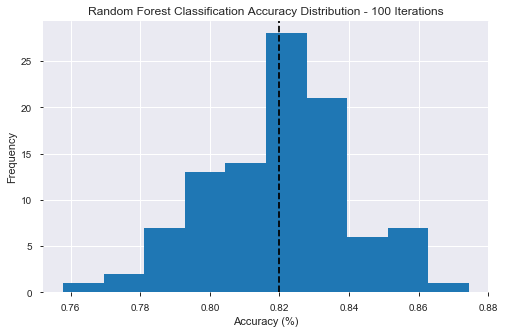

In [486]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(acc_scores)
ax.axvline(x=np.mean(acc_scores), color='black', linestyle='--')
ax.set_xlabel('Accuracy (%)')
ax.set_ylabel('Frequency')
ax.set_title('Random Forest Classification Accuracy Distribution - 100 Iterations');

In [487]:
rf.feature_importances_

array([0.0996868 , 0.11383551, 0.02739659, 0.01401556, 0.14172689,
       0.01715914, 0.00526119, 0.01453308, 0.44186258, 0.04218722,
       0.01105532, 0.06208747, 0.00919266])

## Make predictions on unlabeled data

Below I check the pandas profiling report to see if there are any issues

In [488]:
test.head()

,PassengerId,Age,SibSp,Parch,Fare,Emb_C,Emb_Q,Emb_S,sex_male,class_1,class_2,class_3,Alone
891,892,34.5,0,0,7.8292,0,1,0,1,0,0,1,1
892,893,47.0,1,0,7.0000,0,0,1,0,0,0,1,0
893,894,62.0,0,0,9.6875,0,1,0,1,0,1,0,1
894,895,27.0,0,0,8.6625,0,0,1,1,0,0,1,1
895,896,22.0,1,1,12.2875,0,0,1,0,0,0,1,0


In [489]:
pp.ProfileReport(test)

Now I can use the test dataset to predict on the unlabeled data.

In [490]:
final_clf = RandomForestClassifier(**best_rf_params)
final_clf.fit(X, y)
final_preds = final_clf.predict(test)

In [491]:
submission = pd.DataFrame([])

In [492]:
submission['PassengerId'] = test_index
submission['Survived'] = final_preds

In [493]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [494]:
submission.to_csv('submission_6.csv')